In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from pathlib import Path
from scipy import ndimage, fft
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils import shuffle

In [2]:
def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(['LABEL'], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df['LABEL']).reshape((len(df['LABEL']),1))
    Y = Y_raw == 2
    return X, Y

In [3]:
class LightFluxProcessor:

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    def fourier_transform(self, X):
        return np.abs(np.fft.fft(X, n=X.size))

    def process(self, df_train_x, df_dev_x):
        if self.fourier:
            print("Applying Fourier...")
            df_train_x = np.apply_along_axis(self.fourier_transform, axis=1, arr=df_train_x)
            df_dev_x = np.apply_along_axis(self.fourier_transform, axis=1, arr=df_dev_x)

            df_train_x = df_train_x[:, :(df_train_x.shape[1] // 2)]
            df_dev_x = df_dev_x[:, :(df_dev_x.shape[1] // 2)]

        if self.normalize:
            print("Normalizing...")
            df_train_x = normalize(df_train_x)
            df_dev_x = normalize(df_dev_x)

        if self.gaussian:
            print("Applying Gaussian Filter...")
            df_train_x = ndimage.filters.gaussian_filter(df_train_x, sigma=10)
            df_dev_x = ndimage.filters.gaussian_filter(df_dev_x, sigma=10)

        if self.standardize:
            print("Standardizing...")
            std_scaler = StandardScaler()
            df_train_x = std_scaler.fit_transform(df_train_x)
            df_dev_x = std_scaler.transform(df_dev_x)

        print("Finished Processing!")
        return df_train_x, df_dev_x

In [9]:
from imblearn.over_sampling import SMOTE
def oversampling(train_df):
    model = SMOTE()
    x_train_res,y_train_res = model.fit_resample(train_df.drop('LABEL',axis=1), train_df['LABEL'])
    y_train_res = y_train_res.astype('int')
    
    print(x_train_res.shape, y_train_res.shape)
    return x_train_res, y_train_res


NameError: name 'train_df' is not defined

Loading datasets...
Loaded datasets!
(10100, 3197) (10100,)
Applying Fourier...
Finished Processing!
[[4.12759000e+03 7.96931412e+03 1.97721085e+04 ... 9.15824131e+02
  1.71906192e+03 1.86205440e+03]
 [1.03185000e+03 2.62110570e+03 8.46281714e+03 ... 6.36185312e+02
  9.79579754e+01 3.62982742e+02]
 [2.01568670e+05 2.48077399e+05 5.00639056e+05 ... 4.49430408e+03
  7.50409129e+03 5.28147627e+03]
 ...
 [2.06770000e+04 3.03956347e+04 7.29501933e+04 ... 1.75262246e+03
  4.73144876e+02 3.49070853e+02]
 [2.48999300e+04 6.11438794e+04 9.14777695e+04 ... 3.89396728e+03
  6.51991369e+03 1.71346361e+03]
 [4.09330000e+02 6.90841279e+02 4.47874053e+02 ... 1.34169885e+02
  2.03600618e+02 2.27187060e+02]] [[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]
Describing Datasets...
X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)
n_x:  1598
num_examples:  5087
n_y:  1
Training...


C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished Training!
AUC training set: 0.586
AUC dev set: 0.226
Accuracy training set: 0.998
Accuracy dev set: 0.988
Precision training set: 0.771
Precision dev set: 0.375
Recall training set: 1.000
Recall dev set: 0.600
 


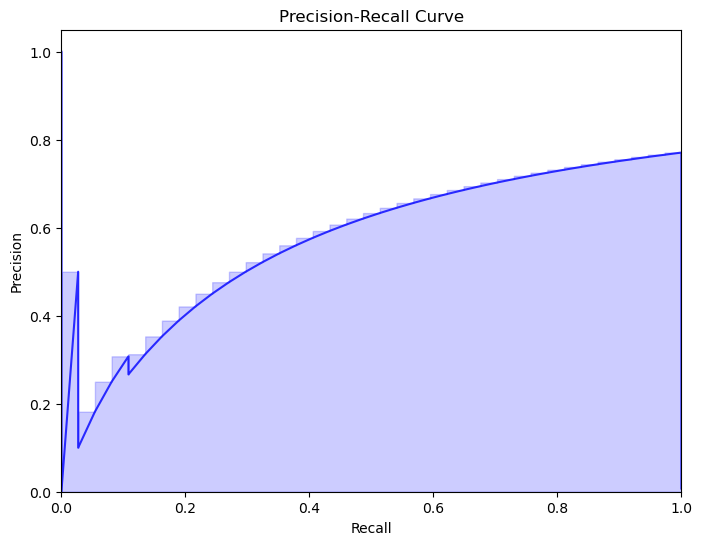

Confusion Matrix - Train Set
[[5039   11]
 [   0   37]]
Confusion Matrix - Dev Set
[[560   5]
 [  2   3]]


In [12]:
def main():
    train_dataset_path = "Data/exoTrain.csv"
    dev_dataset_path = "Data/exoTest.csv"

    print("Loading datasets...")
    df_train = pd.read_csv(train_dataset_path, encoding = "ISO-8859-1")
    df_dev = pd.read_csv(dev_dataset_path, encoding = "ISO-8859-1")
    print("Loaded datasets!")
    oversampling(df_train)
    
#     return None
    df_train_x = df_train.drop('LABEL', axis=1)
    df_dev_x = df_dev.drop('LABEL', axis=1)
    df_train_y = df_train.LABEL
    df_dev_y = df_dev.LABEL
    LFP = LightFluxProcessor(
        fourier=True,
        normalize=False,
        gaussian=False,
        standardize=False)
    df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

    df_train_processed = pd.DataFrame(df_train_x).join(pd.DataFrame(df_train_y))
    df_dev_processed = pd.DataFrame(df_dev_x).join(pd.DataFrame(df_dev_y))

    
    
    X_train, Y_train = np_X_Y_from_df(df_train_processed)
    X_dev, Y_dev = np_X_Y_from_df(df_dev_processed)
    print(X_train, Y_train)
    print("Describing Datasets...")
    (num_examples, n_x) = X_train.shape
    n_y = Y_train.shape[1] 
    print("X_train.shape: ", X_train.shape)
    print("Y_train.shape: ", Y_train.shape)
    print("X_dev.shape: ", X_dev.shape)
    print("Y_dev.shape: ", Y_dev.shape)
    print("n_x: ", n_x)
    print("num_examples: ", num_examples)
    print("n_y: ", n_y)
    
    model = LinearSVC()

    X_train_sm, Y_train_sm = X_train, Y_train

    # Train
    print("Training...")
    model.fit(X_train_sm, Y_train_sm)

    train_outputs = model.predict(X_train_sm)
    dev_outputs = model.predict(X_dev)
    print("Finished Training!")
    

    train_prob = model.decision_function(X_train)  
    dev_prob = model.decision_function(X_dev)


    train_outputs = (train_prob > 0).astype(int)
    dev_outputs = (dev_prob > 0).astype(int)

    accuracy_train = accuracy_score(Y_train_sm, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    precision_train = precision_score(Y_train_sm, train_outputs)
    precision_dev = precision_score(Y_dev, dev_outputs)
    recall_train = recall_score(Y_train_sm, train_outputs)
    recall_dev = recall_score(Y_dev, dev_outputs)
    confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
    classification_report_train = classification_report(Y_train_sm, train_outputs)
    classification_report_dev = classification_report(Y_dev, dev_outputs)

    # Calculate AUC scores
    ap_train = average_precision_score(Y_train_sm, train_prob)
    ap_dev = average_precision_score(Y_dev, dev_prob)

    # Display metrics
    print("AUC training set: %.3f" % ap_train)
    print("AUC dev set: %.3f" % ap_dev)
    print("Accuracy training set: %.3f" % accuracy_train)
    print("Accuracy dev set: %.3f" % accuracy_dev)
    print("Precision training set: %.3f" % precision_train)
    print("Precision dev set: %.3f" % precision_dev)
    print("Recall training set: %.3f" % recall_train)
    print("Recall dev set: %.3f" % recall_dev)
    print(" ")

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(Y_train_sm, train_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', alpha=0.8)
    plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

    # Confusion matrices
    print("Confusion Matrix - Train Set")
    print(confusion_matrix_train)
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix_dev)
    
main()


Loading datasets...
Loaded datasets!
(10100, 3197) (10100,)
Describing Datasets...
X_train.shape:  (10100, 3197)
Y_train.shape:  (10100, 1)
X_dev.shape:  (570, 3197)
Y_dev.shape:  (570, 1)
n_x:  3197
num_examples:  10100
n_y:  1
Training...


C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished Training!
AUC training set: 0.987
AUC dev set: 0.054
Accuracy training set: 0.995
Accuracy dev set: 0.639
Precision training set: 0.990
Precision dev set: 0.014
Recall training set: 1.000
Recall dev set: 0.600
 


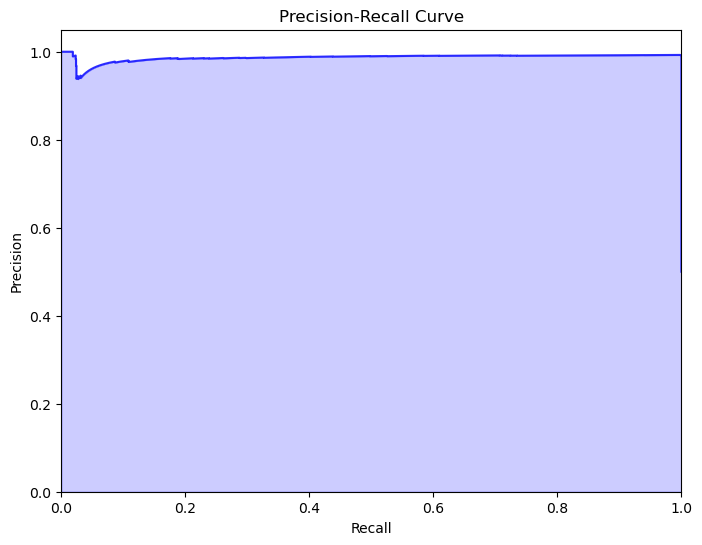

Confusion Matrix - Train Set
[[5000   50]
 [   0 5050]]
Confusion Matrix - Dev Set
[[361 204]
 [  2   3]]


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(['LABEL'], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df['LABEL']).reshape((len(df['LABEL']),1))
    Y = Y_raw == 2
    return X, Y

class LightFluxProcessor:
    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    def fourier_transform(self, X):
        return np.abs(np.fft.fft(X, n=X.size))

    def process(self, df_train_x, df_dev_x):
        if self.fourier:
            df_train_x = np.apply_along_axis(self.fourier_transform, axis=1, arr=df_train_x)
            df_dev_x = np.apply_along_axis(self.fourier_transform, axis=1, arr=df_dev_x)

            df_train_x = df_train_x[:, :(df_train_x.shape[1] // 2)]
            df_dev_x = df_dev_x[:, :(df_dev_x.shape[1] // 2)]

        if self.normalize:
            df_train_x = normalize(df_train_x)
            df_dev_x = normalize(df_dev_x)

        if self.gaussian:
            df_train_x = ndimage.filters.gaussian_filter(df_train_x, sigma=10)
            df_dev_x = ndimage.filters.gaussian_filter(df_dev_x, sigma=10)

        if self.standardize:
            std_scaler = StandardScaler()
            df_train_x = std_scaler.fit_transform(df_train_x)
            df_dev_x = std_scaler.transform(df_dev_x)

        return df_train_x, df_dev_x

def oversampling(train_df):
    model = SMOTE()
    x_train_res, y_train_res = model.fit_resample(train_df.drop('LABEL', axis=1), train_df['LABEL'])
    y_train_res = y_train_res.astype('int')
    print(x_train_res.shape, y_train_res.shape)
    return x_train_res, y_train_res

def main():
    train_dataset_path = "Data/exoTrain.csv"
    dev_dataset_path = "Data/exoTest.csv"

    print("Loading datasets...")
    df_train = pd.read_csv(train_dataset_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_dataset_path, encoding="ISO-8859-1")
    print("Loaded datasets!")

    # Oversampling
    df_train_x_resampled, df_train_y_resampled = oversampling(df_train)
    df_train_resampled = pd.DataFrame(df_train_x_resampled).join(pd.DataFrame(df_train_y_resampled))

    df_train_x = df_train_resampled.drop('LABEL', axis=1)
    df_dev_x = df_dev.drop('LABEL', axis=1)
    df_train_y = df_train_resampled.LABEL
    df_dev_y = df_dev.LABEL

    LFP = LightFluxProcessor(
        fourier=True,
        normalize=False,
        gaussian=False,
        standardize=False)
    
    df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

    X_train, Y_train = np_X_Y_from_df(df_train_resampled)
    X_dev, Y_dev = np_X_Y_from_df(df_dev)

    print("Describing Datasets...")
    (num_examples, n_x) = X_train.shape
    n_y = Y_train.shape[1]
    print("X_train.shape: ", X_train.shape)
    print("Y_train.shape: ", Y_train.shape)
    print("X_dev.shape: ", X_dev.shape)
    print("Y_dev.shape: ", Y_dev.shape)
    print("n_x: ", n_x)
    print("num_examples: ", num_examples)
    print("n_y: ", n_y)

    model = LinearSVC()

    # Train
    print("Training...")
    model.fit(X_train, Y_train)

    train_outputs = model.predict(X_train)
    dev_outputs = model.predict(X_dev)
    print("Finished Training!")

    train_prob = model.decision_function(X_train)
    dev_prob = model.decision_function(X_dev)

    train_outputs = (train_prob > 0).astype(int)
    dev_outputs = (dev_prob > 0).astype(int)

    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    precision_train = precision_score(Y_train, train_outputs)
    precision_dev = precision_score(Y_dev, dev_outputs)
    recall_train = recall_score(Y_train, train_outputs)
    recall_dev = recall_score(Y_dev, dev_outputs)
    confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
    classification_report_train = classification_report(Y_train, train_outputs)
    classification_report_dev = classification_report(Y_dev, dev_outputs)

    # Calculate AUC scores
    ap_train = average_precision_score(Y_train, train_prob)
    ap_dev = average_precision_score(Y_dev, dev_prob)

    # Display metrics
    print("AUC training set: %.3f" % ap_train)
    print("AUC dev set: %.3f" % ap_dev)
    print("Accuracy training set: %.3f" % accuracy_train)
    print("Accuracy dev set: %.3f" % accuracy_dev)
    print("Precision training set: %.3f" % precision_train)
    print("Precision dev set: %.3f" % precision_dev)
    print("Recall training set: %.3f" % recall_train)
    print("Recall dev set: %.3f" % recall_dev)
    print(" ")

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(Y_train, train_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', alpha=0.8)
    plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

    # Confusion matrices
    print("Confusion Matrix - Train Set")
    print(confusion_matrix_train)
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix_dev)

main()


C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


AUC training set: 0.994
AUC dev set: 0.012
Accuracy training set: 0.990
Accuracy dev set: 0.956
Precision training set: 0.988
Precision dev set: 0.000
Recall training set: 0.991
Recall dev set: 0.000


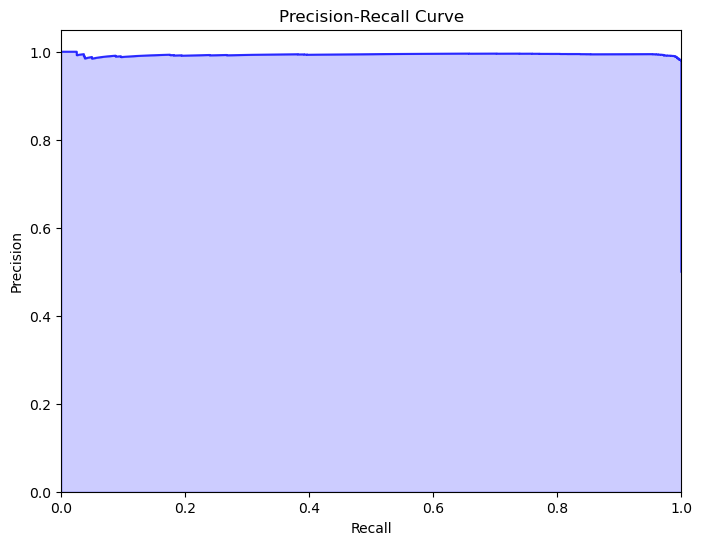

Confusion Matrix - Train Set
[[4989   61]
 [  43 5007]]
Confusion Matrix - Dev Set
[[545  20]
 [  5   0]]


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

def load_datasets(train_path, dev_path):
    df_train = pd.read_csv(train_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_path, encoding="ISO-8859-1")
    
   
    return df_train, df_dev

def preprocess_data(df_train, df_dev):
    df_train = shuffle(df_train)
    df_dev = shuffle(df_dev)

    X_train, Y_train = df_train.drop("LABEL", axis=1), df_train["LABEL"]
    X_dev, Y_dev = df_dev.drop("LABEL", axis=1), df_dev["LABEL"]
    
    Y_train = (Y_train == 2).astype(int)
    Y_dev = (Y_dev == 2).astype(int)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_dev = scaler.transform(X_dev)

    return X_train, Y_train, X_dev, Y_dev

def oversample_data(X_train, Y_train):
    smote = SMOTE()
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
    return X_train_resampled, Y_train_resampled

def train_and_evaluate(X_train, Y_train, X_dev, Y_dev):
    model = LinearSVC()
    model.fit(X_train, Y_train)

    train_outputs = model.predict(X_train)
    dev_outputs = model.predict(X_dev)

    train_prob = model.decision_function(X_train)
    dev_prob = model.decision_function(X_dev)

    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    precision_train = precision_score(Y_train, train_outputs)
    precision_dev = precision_score(Y_dev, dev_outputs)
    recall_train = recall_score(Y_train, train_outputs)
    recall_dev = recall_score(Y_dev, dev_outputs)

    ap_train = average_precision_score(Y_train, train_prob)
    ap_dev = average_precision_score(Y_dev, dev_prob)

    print("AUC training set: %.3f" % ap_train)
    print("AUC dev set: %.3f" % ap_dev)
    print("Accuracy training set: %.3f" % accuracy_train)
    print("Accuracy dev set: %.3f" % accuracy_dev)
    print("Precision training set: %.3f" % precision_train)
    print("Precision dev set: %.3f" % precision_dev)
    print("Recall training set: %.3f" % recall_train)
    print("Recall dev set: %.3f" % recall_dev)

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(Y_train, train_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="b", alpha=0.8)
    plt.fill_between(recall, precision, alpha=0.2, color="b", step="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall Curve")
    plt.show()

    # Confusion matrices
    print("Confusion Matrix - Train Set")
    print(confusion_matrix(Y_train, train_outputs))
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix(Y_dev, dev_outputs))

def main():
    train_dataset_path = "Data/exoTrain.csv"
    dev_dataset_path = "Data/exoTest.csv"

    df_train, df_dev = load_datasets(train_dataset_path, dev_dataset_path)
    X_train, Y_train, X_dev, Y_dev = preprocess_data(df_train, df_dev)
    X_train_resampled, Y_train_resampled = oversample_data(X_train, Y_train)

    train_and_evaluate(X_train_resampled, Y_train_resampled, X_dev, Y_dev)

if __name__ == "__main__":
    main()


Training in progress...


C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training completed.
AUC training set: 0.995
AUC dev set: 0.012
Accuracy training set: 0.990
Accuracy dev set: 0.960
Precision training set: 0.988
Precision dev set: 0.000
Recall training set: 0.992
Recall dev set: 0.000


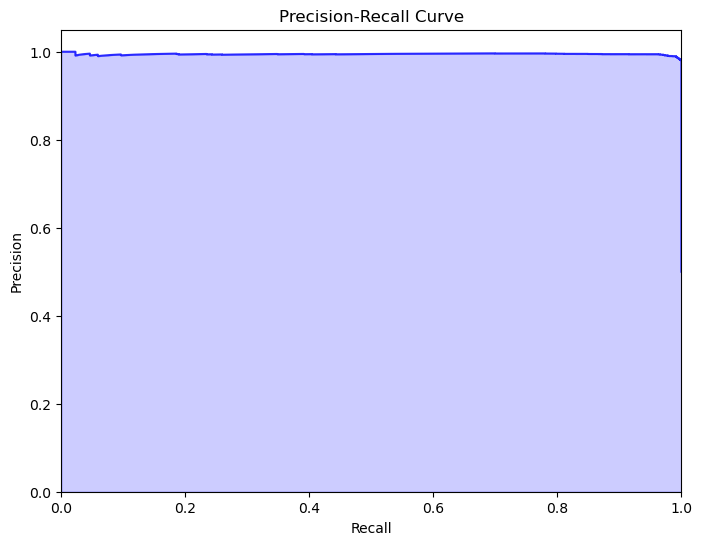

Confusion Matrix - Train Set
[[4990   60]
 [  42 5008]]
Confusion Matrix - Dev Set
[[547  18]
 [  5   0]]


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

def load_datasets(train_path, dev_path):
    df_train = pd.read_csv(train_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_path, encoding="ISO-8859-1")
    return df_train, df_dev

def preprocess_data(df_train, df_dev):
    df_train = shuffle(df_train)
    df_dev = shuffle(df_dev)

    X_train, Y_train = df_train.drop("LABEL", axis=1), df_train["LABEL"]
    X_dev, Y_dev = df_dev.drop("LABEL", axis=1), df_dev["LABEL"]

    # Convert labels to {0, 1}
    Y_train = (Y_train == 2).astype(int)
    Y_dev = (Y_dev == 2).astype(int)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_dev = scaler.transform(X_dev)

    return X_train, Y_train, X_dev, Y_dev

def oversample_data(X_train, Y_train):
    smote = SMOTE()
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
    return X_train_resampled, Y_train_resampled

def train_and_evaluate(X_train, Y_train, X_dev, Y_dev):
    print("Training in progress...")
    model = LinearSVC()
    model.fit(X_train, Y_train)
    print("Training completed.")

    train_outputs = model.predict(X_train)
    dev_outputs = model.predict(X_dev)

    train_prob = model.decision_function(X_train)
    dev_prob = model.decision_function(X_dev)

    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    precision_train = precision_score(Y_train, train_outputs)
    precision_dev = precision_score(Y_dev, dev_outputs)
    recall_train = recall_score(Y_train, train_outputs)
    recall_dev = recall_score(Y_dev, dev_outputs)

    ap_train = average_precision_score(Y_train, train_prob)
    ap_dev = average_precision_score(Y_dev, dev_prob)

    print("AUC training set: %.3f" % ap_train)
    print("AUC dev set: %.3f" % ap_dev)
    print("Accuracy training set: %.3f" % accuracy_train)
    print("Accuracy dev set: %.3f" % accuracy_dev)
    print("Precision training set: %.3f" % precision_train)
    print("Precision dev set: %.3f" % precision_dev)
    print("Recall training set: %.3f" % recall_train)
    print("Recall dev set: %.3f" % recall_dev)

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(Y_train, train_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="b", alpha=0.8)
    plt.fill_between(recall, precision, alpha=0.2, color="b", step="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall Curve")
    plt.show()

    # Confusion matrices
    print("Confusion Matrix - Train Set")
    print(confusion_matrix(Y_train, train_outputs))
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix(Y_dev, dev_outputs))

def main():
    train_dataset_path = "Data/exoTrain.csv"
    dev_dataset_path = "Data/exoTest.csv"

    df_train, df_dev = load_datasets(train_dataset_path, dev_dataset_path)
    X_train, Y_train, X_dev, Y_dev = preprocess_data(df_train, df_dev)
    X_train_resampled, Y_train_resampled = oversample_data(X_train, Y_train)

    train_and_evaluate(X_train_resampled, Y_train_resampled, X_dev, Y_dev)

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

def load_datasets(train_path, dev_path):
    df_train = pd.read_csv(train_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_path, encoding="ISO-8859-1")
    return df_train, df_dev

def preprocess_data(df_train, df_dev):
    df_train = shuffle(df_train)
    df_dev = shuffle(df_dev)

    X_train, Y_train = df_train.drop("LABEL", axis=1), df_train["LABEL"]
    X_dev, Y_dev = df_dev.drop("LABEL", axis=1), df_dev["LABEL"]

    # Convert labels 1 and 2 to 0 and 1
    Y_train = Y_train.map({1: 0, 2: 1})
    Y_dev = Y_dev.map({1: 0, 2: 1})

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
#     X_dev = scaler.transform(X_dev)

    return X_train, Y_train, X_dev, Y_dev

def oversample_data(X_train, Y_train):
    smote = SMOTE()
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
    return X_train_resampled, Y_train_resampled

def train_and_evaluate(X_train, Y_train, X_dev, Y_dev):
    model = SVC(probability=True)  # Using SVC with probability estimates
    model.fit(X_train, Y_train)

    train_outputs = model.predict(X_train)
    dev_outputs = model.predict(X_dev)

    train_prob = model.predict_proba(X_train)[:, 1]
    dev_prob = model.predict_proba(X_dev)[:, 1]

    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    precision_train = precision_score(Y_train, train_outputs)
    precision_dev = precision_score(Y_dev, dev_outputs)
    recall_train = recall_score(Y_train, train_outputs)
    recall_dev = recall_score(Y_dev, dev_outputs)

    ap_train = average_precision_score(Y_train, train_prob)
    ap_dev = average_precision_score(Y_dev, dev_prob)

    print("AUC training set: %.3f" % ap_train)
    print("AUC dev set: %.3f" % ap_dev)
    print("Accuracy training set: %.3f" % accuracy_train)
    print("Accuracy dev set: %.3f" % accuracy_dev)
    print("Precision training set: %.3f" % precision_train)
    print("Precision dev set: %.3f" % precision_dev)
    print("Recall training set: %.3f" % recall_train)
    print("Recall dev set: %.3f" % recall_dev)

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(Y_train, train_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="b", alpha=0.8)
    plt.fill_between(recall, precision, alpha=0.2, color="b", step="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall Curve")
    plt.show()

    # Confusion matrices
    print("Confusion Matrix - Train Set")
    print(confusion_matrix(Y_train, train_outputs))
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix(Y_dev, dev_outputs))

def main():
    train_dataset_path = "Data/exoTrain.csv"
    dev_dataset_path = "Data/exoTest.csv"

    df_train, df_dev = load_datasets(train_dataset_path, dev_dataset_path)
    X_train, Y_train, X_dev, Y_dev = preprocess_data(df_train, df_dev)
    X_train_resampled, Y_train_resampled = oversample_data(X_train, Y_train)

    print("Training and evaluating the model...")
    train_and_evaluate(X_train_resampled, Y_train_resampled, X_dev, Y_dev)

if __name__ == "__main__":
    main()


Training and evaluating the model...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

def load_datasets(train_path, dev_path):
    print("Loading datasets...")
    df_train = pd.read_csv(train_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_path, encoding="ISO-8859-1")
    print("Loaded datasets!")
    return df_train, df_dev

def preprocess_data(df_train, df_dev):
    print("Shuffling datasets...")
    df_train = shuffle(df_train)
    df_dev = shuffle(df_dev)

    print("Splitting features and labels...")
    X_train, Y_train = df_train.drop("LABEL", axis=1), df_train["LABEL"]
    X_dev, Y_dev = df_dev.drop("LABEL", axis=1), df_dev["LABEL"]

    # Convert labels 1 and 2 to 0 and 1
    Y_train = Y_train.map({1: 0, 2: 1})
    Y_dev = Y_dev.map({1: 0, 2: 1})

    print("Scaling features...")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_dev = scaler.transform(X_dev)

    print("Finished preprocessing!")
    return X_train, Y_train, X_dev, Y_dev

def oversample_data(X_train, Y_train):
    print("Oversampling using SMOTE...")
    smote = SMOTE()
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
    print("Finished oversampling!")
    return X_train_resampled, Y_train_resampled

def train_and_evaluate(X_train, Y_train, X_dev, Y_dev):
    print("Initializing and training the model...")
    model = SVC(probability=True)  # Using SVC with probability estimates
    model.fit(X_train, Y_train)
    print("Finished training!")

    print("Making predictions on train and dev sets...")
    train_outputs = model.predict(X_train)
    dev_outputs = model.predict(X_dev)

    train_prob = model.predict_proba(X_train)[:, 1]
    dev_prob = model.predict_proba(X_dev)[:, 1]

    print("Calculating metrics...")
    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    precision_train = precision_score(Y_train, train_outputs)
    precision_dev = precision_score(Y_dev, dev_outputs)
    recall_train = recall_score(Y_train, train_outputs)
    recall_dev = recall_score(Y_dev, dev_outputs)

    ap_train = average_precision_score(Y_train, train_prob)
    ap_dev = average_precision_score(Y_dev, dev_prob)

    print("AUC training set: %.3f" % ap_train)
    print("AUC dev set: %.3f" % ap_dev)
    print("Accuracy training set: %.3f" % accuracy_train)
    print("Accuracy dev set: %.3f" % accuracy_dev)
    print("Precision training set: %.3f" % precision_train)
    print("Precision dev set: %.3f" % precision_dev)
    print("Recall training set: %.3f" % recall_train)
    print("Recall dev set: %.3f" % recall_dev)

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(Y_train, train_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="b", alpha=0.8)
    plt.fill_between(recall, precision, alpha=0.2, color="b", step="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall Curve")
    plt.show()

    # Confusion matrices
    print("Confusion Matrix - Train Set")
    print(confusion_matrix(Y_train, train_outputs))
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix(Y_dev, dev_outputs))

def main():
    train_dataset_path = "Data/exoTrain.csv"
    dev_dataset_path = "Data/exoTest.csv"

    df_train, df_dev = load_datasets(train_dataset_path, dev_dataset_path)
    X_train, Y_train, X_dev, Y_dev = preprocess_data(df_train, df_dev)
    X_train_resampled, Y_train_resampled = oversample_data(X_train, Y_train)

    print("Training and evaluating the model...")
    train_and_evaluate(X_train_resampled, Y_train_resampled, X_dev, Y_dev)

if __name__ == "__main__":
    main()


Loading datasets...
Loaded datasets!
Shuffling datasets...
Splitting features and labels...
Scaling features...
Finished preprocessing!
Oversampling using SMOTE...
Finished oversampling!
Training and evaluating the model...
Initializing and training the model...


Loading datasets...
Loaded datasets!
Shuffling datasets...
Splitting features and labels...
Scaling features...
Finished preprocessing!
Oversampling using SMOTE...
Finished oversampling!
Training and evaluating the model...
Initializing and training the model...
Finished training!
Making predictions on train and dev sets...
Calculating metrics...
AUC training set: 0.657
AUC dev set: 0.048
Accuracy training set: 0.679
Accuracy dev set: 0.991
Precision training set: 0.961
Precision dev set: 0.000
Recall training set: 0.039
Recall dev set: 0.000


C:\Users\vikas\Desktop\exoplanet\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


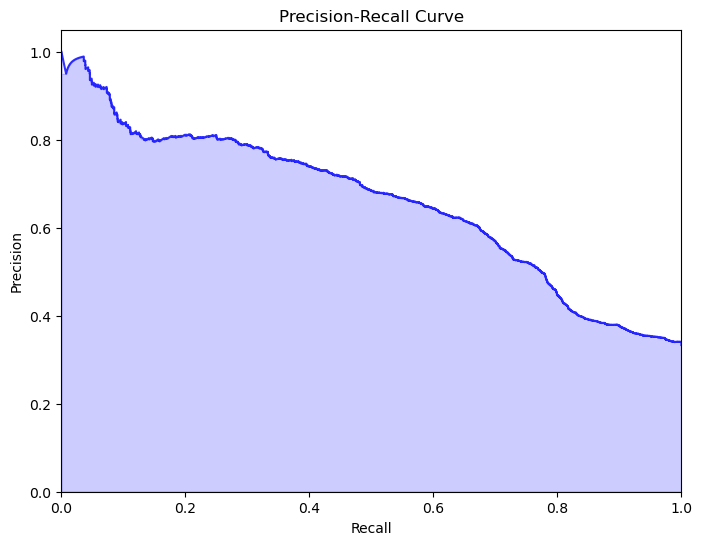

Confusion Matrix - Train Set
[[5046    4]
 [2427   98]]
Confusion Matrix - Dev Set
[[565   0]
 [  5   0]]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

def load_datasets(train_path, dev_path):
    print("Loading datasets...")
    df_train = pd.read_csv(train_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_path, encoding="ISO-8859-1")
    print("Loaded datasets!")
    return df_train, df_dev

def preprocess_data(df_train, df_dev):
    print("Shuffling datasets...")
    df_train = shuffle(df_train)
    df_dev = shuffle(df_dev)

    print("Splitting features and labels...")
    X_train, Y_train = df_train.drop("LABEL", axis=1), df_train["LABEL"]
    X_dev, Y_dev = df_dev.drop("LABEL", axis=1), df_dev["LABEL"]

    # Convert labels 1 and 2 to 0 and 1
    Y_train = Y_train.map({1: 0, 2: 1})
    Y_dev = Y_dev.map({1: 0, 2: 1})

    print("Scaling features...")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_dev = scaler.transform(X_dev)

    print("Finished preprocessing!")
    return X_train, Y_train, X_dev, Y_dev

def oversample_data(X_train, Y_train, sampling_strategy=0.5, k_neighbors=5):
    print("Oversampling using SMOTE...")
    smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors)
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
    print("Finished oversampling!")
    return X_train_resampled, Y_train_resampled

def train_and_evaluate(X_train, Y_train, X_dev, Y_dev):
    print("Initializing and training the model...")
    model = SVC(probability=True)  # Using SVC with probability estimates
    model.fit(X_train, Y_train)
    print("Finished training!")

    print("Making predictions on train and dev sets...")
    train_outputs = model.predict(X_train)
    dev_outputs = model.predict(X_dev)

    train_prob = model.predict_proba(X_train)[:, 1]
    dev_prob = model.predict_proba(X_dev)[:, 1]

    print("Calculating metrics...")
    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    precision_train = precision_score(Y_train, train_outputs)
    precision_dev = precision_score(Y_dev, dev_outputs)
    recall_train = recall_score(Y_train, train_outputs)
    recall_dev = recall_score(Y_dev, dev_outputs)

    ap_train = average_precision_score(Y_train, train_prob)
    ap_dev = average_precision_score(Y_dev, dev_prob)

    print("AUC training set: %.3f" % ap_train)
    print("AUC dev set: %.3f" % ap_dev)
    print("Accuracy training set: %.3f" % accuracy_train)
    print("Accuracy dev set: %.3f" % accuracy_dev)
    print("Precision training set: %.3f" % precision_train)
    print("Precision dev set: %.3f" % precision_dev)
    print("Recall training set: %.3f" % recall_train)
    print("Recall dev set: %.3f" % recall_dev)

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(Y_train, train_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="b", alpha=0.8)
    plt.fill_between(recall, precision, alpha=0.2, color="b", step="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall Curve")
    plt.show()

    # Confusion matrices
    print("Confusion Matrix - Train Set")
    print(confusion_matrix(Y_train, train_outputs))
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix(Y_dev, dev_outputs))

def main():
    train_dataset_path = "Data/exoTrain.csv"
    dev_dataset_path = "Data/exoTest.csv"

    df_train, df_dev = load_datasets(train_dataset_path, dev_dataset_path)
    X_train, Y_train, X_dev, Y_dev = preprocess_data(df_train, df_dev)
    X_train_resampled, Y_train_resampled = oversample_data(X_train, Y_train, sampling_strategy=0.5, k_neighbors=5)

    print("Training and evaluating the model...")
    train_and_evaluate(X_train_resampled, Y_train_resampled, X_dev, Y_dev)

main()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.utils import shuffle

def load_datasets(train_path, dev_path):
    print("Loading datasets...")
    df_train = pd.read_csv(train_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_path, encoding="ISO-8859-1")
    print("Loaded datasets!")
    return df_train, df_dev

def preprocess_data(df_train, df_dev):
    print("Shuffling datasets...")
    df_train = shuffle(df_train)
    df_dev = shuffle(df_dev)

    print("Splitting features and labels...")
    X_train, Y_train = df_train.drop("LABEL", axis=1), df_train["LABEL"]
    X_dev, Y_dev = df_dev.drop("LABEL", axis=1), df_dev["LABEL"]

    # Convert labels 1 and 2 to 0 and 1
    Y_train = Y_train.map({1: 0, 2: 1})
    Y_dev = Y_dev.map({1: 0, 2: 1})

    print("Scaling features...")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_dev = scaler.transform(X_dev)

    print("Generating polynomial features and interactions...")
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_dev_poly = poly.transform(X_dev)

    print("Finished preprocessing!")
    return X_train_poly, Y_train, X_dev_poly, Y_dev

def train_and_evaluate(X_train, Y_train, X_dev, Y_dev):
    print("Initializing and training the model...")
    model = SVC(probability=True)  # Using SVC with probability estimates
    model.fit(X_train, Y_train)
    print("Finished training!")

    print("Making predictions on train and dev sets...")
    train_outputs = model.predict(X_train)
    dev_outputs = model.predict(X_dev)

    train_prob = model.predict_proba(X_train)[:, 1]
    dev_prob = model.predict_proba(X_dev)[:, 1]

    print("Calculating metrics...")
    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    precision_train = precision_score(Y_train, train_outputs)
    precision_dev = precision_score(Y_dev, dev_outputs)
    recall_train = recall_score(Y_train, train_outputs)
    recall_dev = recall_score(Y_dev, dev_outputs)

    ap_train = average_precision_score(Y_train, train_prob)
    ap_dev = average_precision_score(Y_dev, dev_prob)

    print("AUC training set: %.3f" % ap_train)
    print("AUC dev set: %.3f" % ap_dev)
    print("Accuracy training set: %.3f" % accuracy_train)
    print("Accuracy dev set: %.3f" % accuracy_dev)
    print("Precision training set: %.3f" % precision_train)
    print("Precision dev set: %.3f" % precision_dev)
    print("Recall training set: %.3f" % recall_train)
    print("Recall dev set: %.3f" % recall_dev)

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(Y_train, train_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="b", alpha=0.8)
    plt.fill_between(recall, precision, alpha=0.2, color="b", step="post")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall Curve")
    plt.show()

    # Confusion matrices
    print("Confusion Matrix - Train Set")
    print(confusion_matrix(Y_train, train_outputs))
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix(Y_dev, dev_outputs))

def main():
    train_dataset_path = "Data/exoTrain.csv"
    dev_dataset_path = "Data/exoTest.csv"

    df_train, df_dev = load_datasets(train_dataset_path, dev_dataset_path)
    X_train, Y_train, X_dev, Y_dev = preprocess_data(df_train, df_dev)

    print("Training and evaluating the model...")
    train_and_evaluate(X_train, Y_train, X_dev, Y_dev)

if __name__ == "__main__":
    main()


Loading datasets...
Loaded datasets!
Shuffling datasets...
Splitting features and labels...
Scaling features...
Generating polynomial features and interactions...


MemoryError: Unable to allocate 194. GiB for an array with shape (5087, 5115200) and data type float64